# __Unsupervised Learning Project__

### __Project Topic__
This project is meant to determine how different approaches to image compression (via feature extraction techniques) affect the relative accuracy and time-efficiency of certain machine learning models, when applied to a high-dimensional image classifiecation problem.

The compression performed on images will be done through Singular Value Decomposition, and will employ both sklearn's PCA, as well as TruncatedSVD. The prediction ability of supervised learning models such as SVC and Random Forests will then be tested on the compressed and noncompressed image sets, which will be determined by accuracy. The time taken to fully implement each approach will also be measured and compared. Lastly, a confusion matrix of the best performing model will be provided.

The classification problem itself has 101-classes, many of which have "doppelgangers", classes that look visually similar, if not identical. As such, I have personally made a subset of it containing 67 classes. There are also ~7000 images total. It should serve as a decent stress-test.

### __Purpose__

My goal in this project is twofold:

-I want to create a model for compressing images, that allows a classifier to perform much faster with minimal loss in performance.

-I want to establish which compression technique between SVC and TruncatedSVD, are superior for this application (if any), in terms of time-efficiency and accuracy. 

Given a square matrix (which these images will be), SVD and PCA are mathematically equivalent. However truncatedSVD is meant to have speed optimizations, and is truncated by nature, so it's not clear which would do better.

In [1]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.datasets import load_files
from skimage.transform import resize
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import MinMaxScaler
from skimage.io import imread
import warnings


In [2]:
#ignore future warnings
warnings.simplefilter("ignore", FutureWarning)

In [3]:
#helper function for creating a matrix with image dimensions encoded into it.
#np.shape returns ragged values for a mix of RGB and BW images
def extract_res_from_images(data):
    shapes = np.zeros((len(data),3))
    for i, image in enumerate(data):
        #print(np.shape(image))
        if len(np.shape(image)) != 3:
            shapes[i][0],shapes[i][1], = np.shape(image)
            shapes[i][2] = 1
        else:
            shapes[i] = np.shape(image)
    return shapes


### __Data__

The dataset used for this project is the Caltech-101 dataset, which contains approximately 7000 images, across 67 categories. Categories that contained near visually identical images have been removed, for obvious reasons. The relevant paper and DOI can be found in the references section at the end of the notebook.

This project focuses entirely on the ObjectCategories folder within the dataset, with each folder pertaining to a different object category, as the name suggests. 

In [4]:
#load files
data_dir = "/UL_final_project/101_ObjectCategories/"
data = load_files(data_dir, categories= None,shuffle = True, decode_error="ignore",random_state=42)

In [5]:
#read images and establish categories
img = [imread(i) for i in data["filenames"]]
encoded = data["target"]
categories = [data["target_names"][i] for i in encoded]

# EDA and Cleaning

##### 1) Image dimensional analysis & BW removal

Each image within the dataset has three dimensions to it, the pixel column, the pixel row, and the pixel values. For a color image, the pixel value is a 3-value list that corresponds to the Red,Green,and Blue value for the image respectively. Let's start with some analysis relevant to that

In [6]:
#generates the horizontal, vertical, and color dimensions of the data.
shapes_fixed = extract_res_from_images(img)
hori,vert,dim = shapes_fixed[:,[1,0,2]].T

Below are histograms for the horizontal resolution of images. There are a few very large outliers, but the data is mostly centered at 300 pixels, with a gap between 300 and 400 pixels.

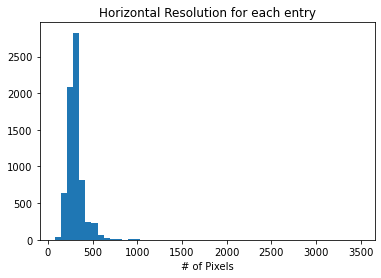

In [7]:
plt.title("Horizontal Resolution for each entry")
plt.xlabel("# of Pixels")
plt.hist(hori,bins = 50)
plt.show()

Zoomed-in histogram without outliers, making the gap visible

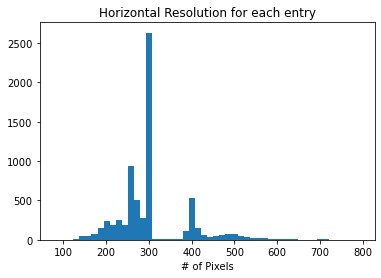

In [8]:
plt.title("Horizontal Resolution for each entry")
plt.xlabel("# of Pixels")
plt.hist(hori[hori<800],bins = 50)
plt.show()

Below are histograms for the vertical resolutions of images. The vetical resolution also has large outliers and a mode of 300, but there's also a clear distribution around 150, suggesting that a close to 2:1 is also a common aspect ratio if 300 horizontal pixels is common. 

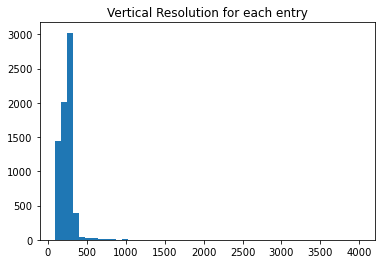

In [9]:
plt.title("Vertical Resolution for each entry")
plt.hist(vert,bins = 50)
plt.show()

Zoomed-in histogram of vertical resolutions

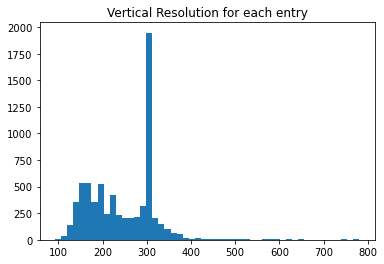

In [10]:
plt.title("Vertical Resolution for each entry")
plt.hist(vert[vert<800],bins = 50)
plt.show()

Histogram for color dimensions of each entry

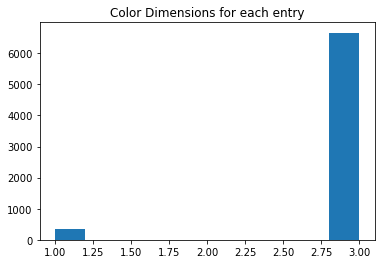

In [11]:
plt.title("Color Dimensions for each entry")
plt.hist(dim)
plt.show()

There are only two entries for this, 1, which corresponds to a black and white image, and 3, which corresponds to a colored RGB image. For this project, I am only interested in the processing and classification of RGB images, since it can be a very important feature when comparing compressed images. If you see a highly compressed image that is blue, are you more likely to say that it's a dog, or a fish in water?


As such, black and white images are to be removed from the entire dataset

In [12]:
# Remove all black and white images from the dataset
remove_bw = dim != 1
data_nbw = np.array(img)[remove_bw]
categories_nbw = np.array(categories)[remove_bw]


C:\Users\Angel\AppData\Local\Temp\ipykernel_11116\1543824634.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_nbw = np.array(img)[remove_bw]


Now that that's been taken care of, let's get an idea of what the categorical counts of the dataset looks like, to see if there are any obvious categorical biases.

##### 2) Categorical analysis & downsampling of training data

In [13]:
#make a pandas series out of the categories array
#use it to calculate the average number of categories
cseries_nbw = pd.Series(categories_nbw)
minrep = int(cseries_nbw.value_counts().mean())

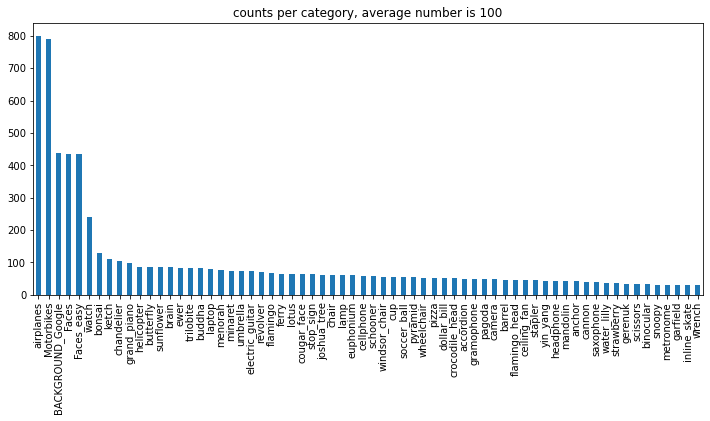

In [14]:
plt.figure(figsize = (12,5))
cseries_nbw.value_counts().plot(kind = "bar", rot = 90)
plt.title("counts per category, average number is {}".format(minrep))
plt.show()

In [15]:
counts = cseries_nbw.value_counts()
mincat, nummin = counts.idxmin(),counts.min()
maxcat, nummax = counts.idxmax(),counts.max()

print("Least common category is {}, appearing {} times".format(mincat,nummin))
print("Most common category is {}, appearing {} times".format(maxcat,nummax))

Least common category is wrench, appearing 29 times
Most common category is airplanes, appearing 800 times


The categorical distribution of the data is very uneven, which could easily cause issues when we train our classifiers, and must be adjusted. We can't expect to classify "inline_skates" when "airplanes" appears over 27 times more than it.

In order to lessen the biases present within the training data, I'll use the average number of entries within the training data as a cutoff point for each category. It allows the most common datasets to still be well-represented, without losing too much of the training data. 

In [16]:
x_train,x_test,y_train,y_test = train_test_split(data_nbw,categories_nbw, random_state = 42)
x_train,y_train = np.array(x_train),np.array(y_train)
cseries_nbw_train = pd.Series(y_train)
minrep = int(cseries_nbw_train.value_counts().mean())
print("Average number of categories for training set is {}".format(minrep))

Average number of categories for training set is 75


Shown above is the average number per category for the training set. Given this value, the below algorithm attempts to randomly sample this many indices belonging to entries of each category. If there's less than this amount, it just takes the entire category.

In [17]:
np.random.seed(42)
grouped = cseries_nbw_train.groupby(cseries_nbw_train).groups
sampled_indices = []
for category in grouped:
    try:
        indices = np.random.choice(grouped[category],size = minrep,replace = False)
    except:
        indices = grouped[category]
    sampled_indices.extend(indices)

Using these indices, creates the downsampled version of each training dataset

In [18]:
x_nbw_samp = x_train[sampled_indices]
y_nbw_samp = y_train[sampled_indices]
#just renaming y_nbw_samp to y_train to make it less confusing
y_train = y_nbw_samp

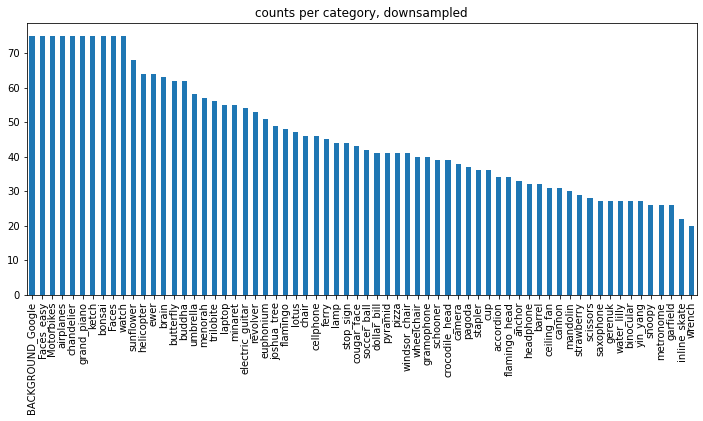

In [19]:
plt.figure(figsize = (12,5))
cseries_dsmp = pd.Series(y_train)
cseries_dsmp.value_counts().plot(kind = "bar", rot = 90)
plt.title("counts per category, downsampled")
plt.show()

Although it's not perfect, it allows the majority of the categories to remain whole, allows reasonable emphasis placed on the most common categories, while not completely drowning out the least common ones.


With this done, the data must now be transformed into a format compatible with SVD and PCA

#### 3) Image Resizing

For this part of the process, each image within both the training and test will be transformed, resized into 150x150 square matrices. 
There are a few reasons for choosing 150X150, the most pressing being computational cost, so I chose resolutions that was half that of the most common ones for vertical and horizontal resolutions.

Having the matrices be square is also important for my comparison between sklearn's implementation of PCA and TruncatedSVD. Under the condition of a square matrix, PCA and SVD should be equivalent, so performing both on the same square matrices should help highlight any differences between them. 

In [20]:
x_nbw_resize = np.array([resize(image,(150,150)) for image in x_nbw_samp])
x_test_nbw_resize = np.array([resize(image,(150,150)) for image in x_test])

The supervised learning models can now be made using this data

# Unsupervised Learning: 
# SVD and PCA for Image Compression

SVD and PCA are both feature extraction techniques using matrix factorization, with PCA being a "special case" of PCA for square matrices which simplifies things. 

In [21]:
print(150*150*3)

67500


SVD is the decomposition of a matrix $ M $ into three other matrices of smaller size, taking the shape of:

$ M = U \Sigma V^T $

where $M$ is an mxn matrix we want to decompose, $U$ is an mxm matrix composed eigenvectors of $MM^T$, $V$ is composed of eigenvectors of $M^T M$, of size nxn, and $\Sigma$ is a dxd diagonal matrix composed of the square roots of both $M$ and $V$'s eigenvalues. 

Using this technique can allow us to effectively compress each image within our set from having 150x150x3=67500 features, to however many features necessary to acheive the accuracy that we want.

In this sense, SVD can behave very well as a type of image compression, so it will be applied to each one, using sklearn's TruncatedSVD and PCA, for 100,200,300, and 400 dimensions respectively.

In [22]:
x_train_ex = x_nbw_resize.reshape(len(x_nbw_resize),-1)
x_test_ex = x_test_nbw_resize.reshape(len(x_test_nbw_resize),-1)

In [23]:
# important data that will be needed later on
times_taken_svd = []
svd_n = []
x_train_svd_arr = []
x_test_svd_arr = []
svd_models = []

for n in np.arange(25,225,25):
    start_time = time.time()
    x_train_baseline = x_train_ex
    x_test_baseline = x_test_ex
    #creates the model
    SVDmodel = TruncatedSVD(n_components = n, random_state = 42)
    #fits and transforms
    x_train_svd =SVDmodel.fit_transform(x_train_baseline)
    x_test_svd = SVDmodel.transform(x_test_baseline)
    end_time = time.time()
    times_taken_svd.append(end_time - start_time)
    svd_n.append(n)
    x_train_svd_arr.append(x_train_svd)
    x_test_svd_arr.append(x_test_svd)



In [24]:
times_taken_pca = []
pca_n = []
x_train_pca_arr = []
x_test_pca_arr = []
pca_models = []

for n in np.arange(25,225,25):
    start_time = time.time()
    x_train_baseline = x_train_ex
    x_test_baseline = x_test_ex

    PCAmodel = PCA(n_components = n, random_state = 42)
    
    x_train_pca =PCAmodel.fit_transform(x_train_baseline)
    x_test_pca = PCAmodel.transform(x_test_baseline)
    end_time = time.time()
    times_taken_pca.append(end_time - start_time)
    pca_n.append(n)
    x_train_pca_arr.append(x_train_pca)
    x_test_pca_arr.append(x_test_pca)
    


I should note here that between the two, the PCA model exhibited higher instability than the TruncatedSVD model at high dimensions. At the 400 dimensions mark, it is fairly common for the PCA model to fail to converge and not finish. The TruncatedSVD model only seems to do this sometimes at 500 n_dimensions, with PCA seemingly always failing.

Here are the results for the time taken to create each unsupervised model

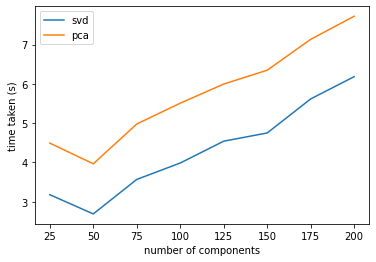

In [25]:
n_cmp = np.arange(25,225,25)
plt.plot(n_cmp,times_taken_svd,label = "svd")
plt.plot(n_cmp,times_taken_pca,label = "pca")
plt.xlabel("number of components")
plt.ylabel("time taken (s)")
plt.legend()
plt.show()

These are some interesting results, as TruncatedSVD seemed to consistently outperform PCA, for each 
I suspect that it has something to do with when and how the algorithms implement parallel processing, despite neither function allowing you to control it with an n_jobs parameter.

Now that those models are made, let's get a look at what these compressed, decomposed images look like. I'll only be using the highest dimensional case from each of them, since they lose visual coherence very quickly as the number of dimensions decreases.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'reconstructed PCA, 200 components')

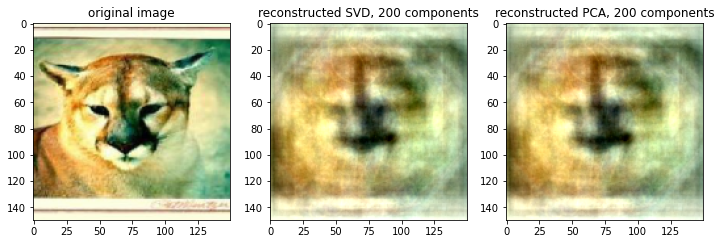

In [26]:
image_num = 1050

fig, axs = plt.subplots(1,3, figsize = (12,5))
axs[0].imshow(x_train_ex[image_num].reshape(150,150,3))
axs[0].set_title("original image")

x_inverse_svd = SVDmodel.inverse_transform(x_train_svd)
testim_svd = np.array(x_inverse_svd[image_num]).reshape(150,150,3)
axs[1].imshow(testim_svd)
axs[1].set_title("reconstructed SVD, 200 components")

x_inverse_pca = PCAmodel.inverse_transform(x_train_pca)
testim_pca = np.array(x_inverse_pca[image_num]).reshape(150,150,3)
axs[2].imshow(testim_pca)
axs[2].set_title("reconstructed PCA, 200 components")

In SVD, eigenimages represent the most well-defined features and variations within a set of images, and can be pretty interesting to see.

To further illustrate the mopdels, as well as their similarities and differences, the following are the first 25 eigenimages from the two of them.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 0.98, 'SVD eigenimages')

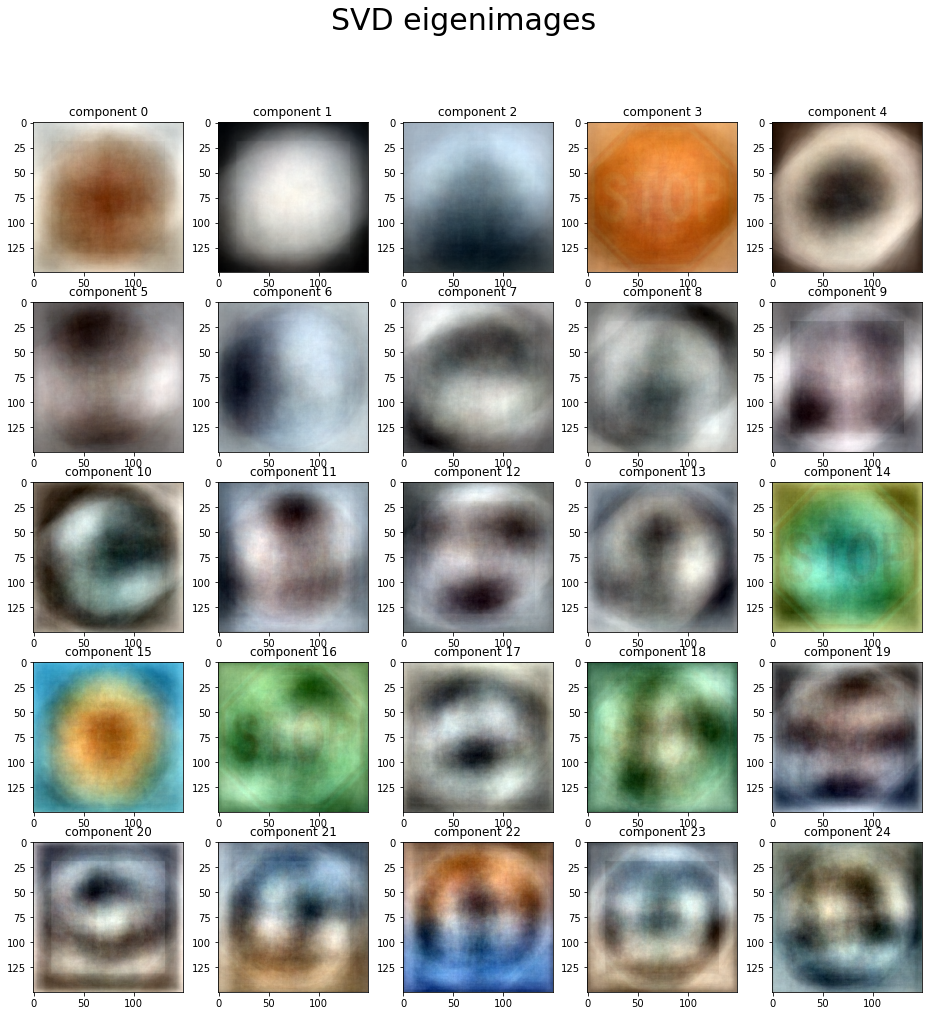

In [27]:
fig, axs = plt.subplots(5,5, figsize = (16,16))
num_eigen = 25
for i in range(num_eigen):

    x_svd = np.array(SVDmodel.components_[i]).reshape(-1,1)
    scaler = MinMaxScaler()
    x_mnmx = scaler.fit_transform(x_svd)
    x_reshaped = x_mnmx.reshape(150,150,3)
    row,col = i//5,i%5
    axs[row,col].imshow(x_reshaped)
    axs[row,col].set_title("component {}".format(i))
fig.suptitle("SVD eigenimages", fontsize = 30)

Text(0.5, 0.98, 'PCA eigenimages')

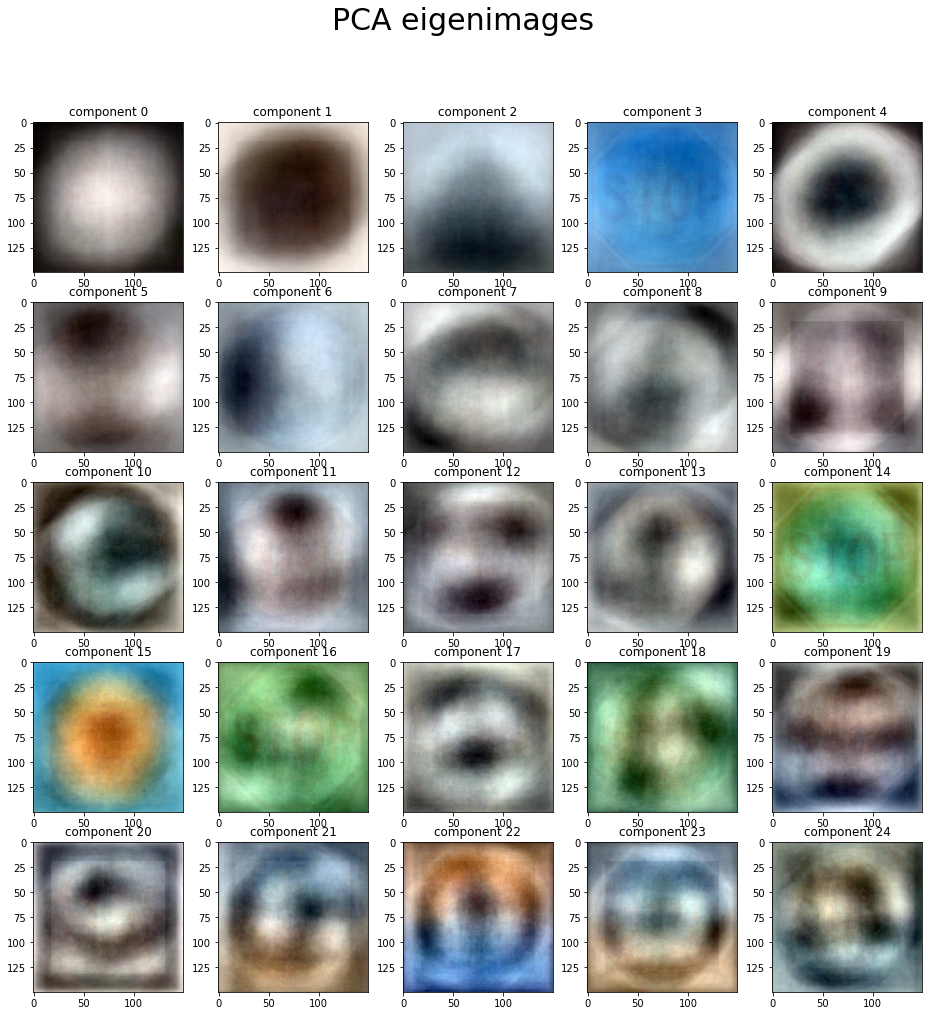

In [28]:
fig, axs = plt.subplots(5,5, figsize = (16,16))
num_eigen = 25
for i in range(num_eigen):

    x_pca = np.array(PCAmodel.components_[i]).reshape(-1,1)
    scaler = MinMaxScaler()
    x_mnmx = scaler.fit_transform(x_pca)
    x_reshaped = x_mnmx.reshape(150,150,3)
    row,col = i//5,i%5
    axs[row,col].imshow(x_reshaped)
    axs[row,col].set_title("component {}".format(i))
fig.suptitle("PCA eigenimages",fontsize = 30)

The two sets of eigenimages are largely the same, with only a few particular components varying. These are components 0,1 and 3, but each seems to have the same latent features generally encoded in them, but just have some sort of color/alpha inversion applied to them, which can happen. 

I think it's also interesting to see eigenimages that have color gradients encoded into them, for once rather than just simple features.

Also, the stop sign seems to be such a well-defined class of images that it's very much visible in a handful of components, despite not being over-represented in the data.

With these transformed image sets, we can now move onto classifying our results with supervised learning

# Unsupervised + Supervised Learning Models

Now, given all of the transformed data, it's time to do some classification on it. Both random Forests and Support Vector Classification will be used, as they both performed fairly well on the baseline case, with decent times.

In order to do this, all data transformed and taken thus far has to be properly organized so it that can fit neatly in a loop, and the final results for each model can be collected. This is done below

In [29]:
n_components = np.arange(25,225,25)
x_train_arr = [x_train_baseline]
x_test_arr = [x_test_baseline]
typesofmodels = ["Baseline"]
time_to_add = [0]

for i,n in enumerate(n_components.astype(int)):
    x_train_arr.append(x_train_svd_arr[i])
    x_test_arr.append(x_test_svd_arr[i])
    typesofmodels.append("SVD_" + str(n))
    time_to_add.append(times_taken_svd[i])
 
    x_train_arr.append(x_train_pca_arr[i])
    x_test_arr.append(x_test_pca_arr[i])
    typesofmodels.append("PCA_" + str(n))
    time_to_add.append(times_taken_pca[i])


Now, both Random Forest and Support Vector Classification is performed on each kind of training/test sets, from the baseline set, to the variety of data transformed via PCA and TruncatedSVD. Accuracy, total time for the approach, the number of components, and the relevant models are then stored in a pandas dataframe so that some relevant analysis can be conducted on them 

In [30]:
resultsdf = pd.DataFrame(columns = ["n_components","model name","time_taken","accuracy score"])

#predictions are stored in here so that a confusion matrix of the best performing model can be made later
prediction_arr = []

for i,modeltype in enumerate(typesofmodels):
    x_train_current,x_test_current = x_train_arr[i],x_test_arr[i]

    svc_lin = SVC(kernel = 'linear', C = 0.0001, random_state = 42)
    rfc = RandomForestClassifier(n_estimators = 1000, n_jobs = -1, random_state = 42)
    
    modelnames = ["SVC", "Random Forest Classifier"]
    models_totry = [svc_lin,rfc]

    
    for j,model in enumerate(models_totry):
        start_time = time.time()
        model.fit(x_train_current,y_train)
        predictions = model.predict(x_test_current)
        end_time = time.time()
        accuracy = accuracy_score(predictions,y_test)
        time_taken = end_time-start_time
    
        row_data = [np.shape(x_train_current)[1],modelnames[j] +" "+ modeltype,time_taken + time_to_add[i],accuracy]
        resultsdf = resultsdf.append(pd.Series(row_data, index = resultsdf.columns), ignore_index=True)
        prediction_arr.append(predictions)


Now it's time to take our results and organized format, so that they can be plotted.

In [31]:
RFC_df = resultsdf[resultsdf["model name"].str.contains("Random")]
RFC_SVD = RFC_df[RFC_df["model name"].str.contains("SVD")]
RFC_PCA = RFC_df[RFC_df["model name"].str.contains("PCA")]

SVC_df = resultsdf[resultsdf["model name"].str.contains("SVC")]
SVC_SVD = SVC_df[SVC_df["model name"].str.contains("SVD")]
SVC_PCA = SVC_df[SVC_df["model name"].str.contains("PCA")]

Using these we can move on to discussing the results and conclusions

#### __Results__

Now, let's plot the results of PCA and SVD models agains our baseline models that were trained with 67500 components

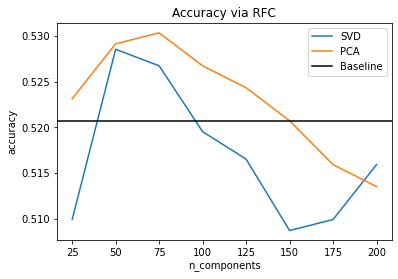

In [32]:
plt.plot(RFC_SVD["n_components"],RFC_SVD["accuracy score"], label = "SVD")
plt.plot(RFC_PCA["n_components"],RFC_PCA["accuracy score"], label = "PCA")
plt.axhline(RFC_df["accuracy score"].iloc[0], c = "black", label = "Baseline")
plt.ylabel("accuracy")
plt.xlabel("n_components")
plt.title("Accuracy via RFC")
plt.legend()
plt.show()

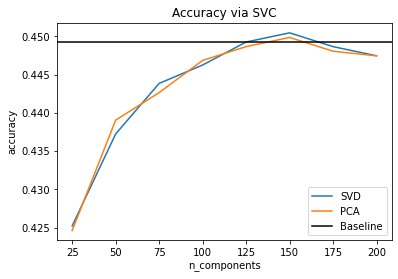

In [33]:
plt.plot(SVC_SVD["n_components"],SVC_SVD["accuracy score"], label = "SVD")
plt.plot(SVC_PCA["n_components"],SVC_PCA["accuracy score"], label = "PCA")
plt.axhline(SVC_df["accuracy score"].iloc[0], c = "black", label = "Baseline")
plt.ylabel("accuracy")
plt.xlabel("n_components")
plt.title("Accuracy via SVC")
plt.legend()
plt.show()

Here we see the supervised learning versions of the models manage to outperform the baseline version that was composed of 67500 components.

For the Random Forest Classifier, PCA Generally performed the best, and was able to have the highest accuracy score out of any of the models.

For the Support Vector Classifier, neither model generally seemed to perform better than the other. TruncatedSVD was able to have the highest accuracy score, but the difference between the two always remained _very_ small.

Now for the graphs of time taken

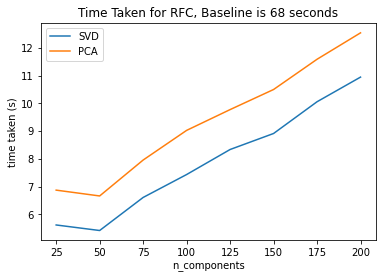

In [34]:
plt.plot(RFC_SVD["n_components"],RFC_SVD["time_taken"], label = "SVD")
plt.plot(RFC_PCA["n_components"],RFC_PCA["time_taken"], label = "PCA")

plt.ylabel("time taken (s)")
plt.xlabel("n_components")
plt.title("Time Taken for RFC, Baseline is {:.0f} seconds".format(RFC_df["time_taken"].iloc[0]))
plt.legend()
plt.show()

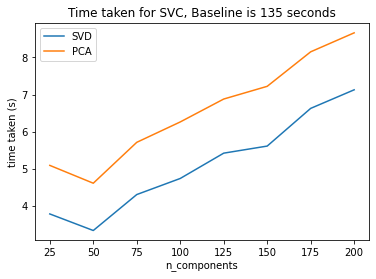

In [35]:
plt.plot(SVC_SVD["n_components"],SVC_SVD["time_taken"], label = "SVD")
plt.plot(SVC_PCA["n_components"],SVC_PCA["time_taken"], label = "PCA")

plt.ylabel("time taken (s)")
plt.xlabel("n_components")
plt.title("Time taken for SVC, Baseline is {:.0f} seconds".format(SVC_df["time_taken"].iloc[0]))
plt.legend()
plt.show()

Out of both models, TruncatedSVD was able to be consistently faster than PCA, usually by about a full second.

Below are the final results for the model with the highest accuracy.

In [36]:
max_acc_idx = 13
best = RFC_PCA.iloc[2]
best

n_components                                   75
model name        Random Forest Classifier PCA_75
time_taken                               7.955222
accuracy score                            0.53033
Name: 13, dtype: object

Finally, here is a confusion matrix heatmap for the best performing model

<AxesSubplot:>

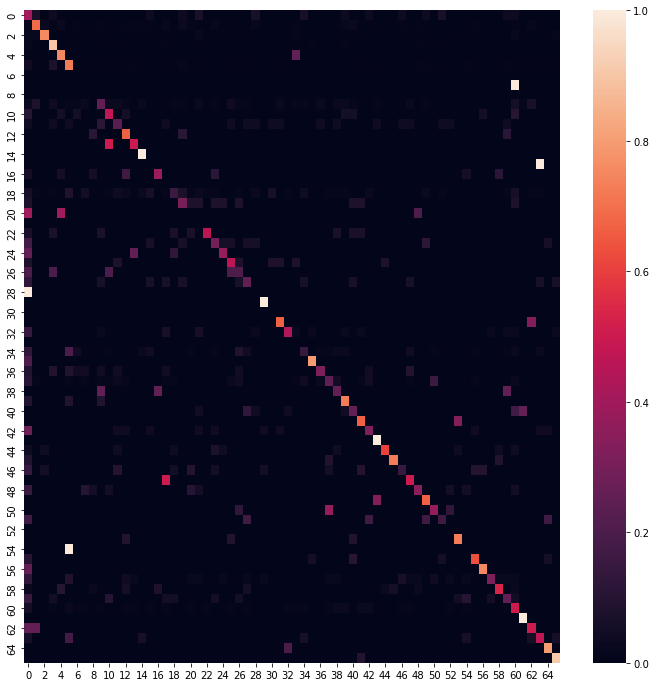

In [37]:
plt.figure(figsize = (12,12))
cm = confusion_matrix(prediction_arr[13],y_test, normalize= "true")

sns.heatmap(cm)

There are many classes well-established on the diagonal, however, there are also clearly many that have not been correctly classified at all, with a completely different category being recognized as them for quite a few of these, so the 53% accuracy makes sense.

# Discussion and Conclusion

Overall, I am very happy with how these results turned out, but they are not without their issues.

Using PCA, I was able to create a feature extraction model that allowed a random forest model to not only run many times faster than it previously did, but use 900 times fewer features, and _still_ perform better.

I was also able to establish some kind of clear performance difference between PCA and TruncatedSVD. PCA generally returned better results (given some models), but TruncatedSVD was consistently faster, both of which are expected.

As far as the accuracy of the model is concerned, 53% accuracy doesn't sound great at first, but it is when you consider what the models have to work with. There are 67 different classes, and although there are no longer many that immediately look visually similar, there are still plenty that share features composing the much of the image. For example, an image of a bird flying in the sky may be seen as having a lot in common with a landscape photo of a building, because of the large blue sky that takes up much of the image. With just guessing, the chances of being correct are ~1.5%, so I would say that 53% is pretty solid.

As for improving this project, I think it would be interesting to see if it could improved with image processing techniques that remove some backgrounds altogether, and replace it with a neutral value. This may allow a model to focus more on the subject of an image, rather than the entirety of it. It would also be interesting to see how this image compression would affect a deep learning algorithm that already has a high accuracy on the base dataset.

### __Citations__

_Li, F.-F., Andreeto, M., Ranzato, M., & Perona, P. (2022). Caltech 101 (1.0)_

DOI = https://doi.org/10.22002/D1.20086